In [151]:
import pickle
import os
import copy

itr = 215
# samples_folder = "ppo-point-embed-tanh/ppo_point_embed_tanh_2018_08_21_19_27_48_0001"
samples_folder = "ppo-point-embed-makeplots/ppo_point_embed_makeplots_2018_08_21_19_59_46_0001"
samples_folder = "sawyer-reach-embed-tanh/sawyer_reach_embed_tanh_2018_08_21_19_31_34_0001"

samples_file = "samples_%i.pkl" % itr
data_dir = os.path.join(os.getcwd(), "../../../data/local")
with open(os.path.join(data_dir, samples_folder, samples_file), "rb") as fin:
    samples = pickle.load(fin)
samples.keys()
ntasks = samples["tasks"][0].shape[1]
tasks = {}
for i in range(len(samples["tasks"])):
    task = np.argmax(samples["tasks"][i][0])
    if not task in tasks:
        tasks[task] = [i]
    else:
        tasks[task].append(i)
task_nums = ", ".join("%i x task %i" % (len(tasks[task]), task) for task in range(ntasks))
print('Loaded %i trajectories (%s).' % (len(samples["tasks"]), task_nums))

Loaded 171 trajectories (20 x task 0, 22 x task 1, 20 x task 2, 20 x task 3, 21 x task 4, 23 x task 5, 24 x task 6, 21 x task 7).


Tasks: 8
Latents: 3


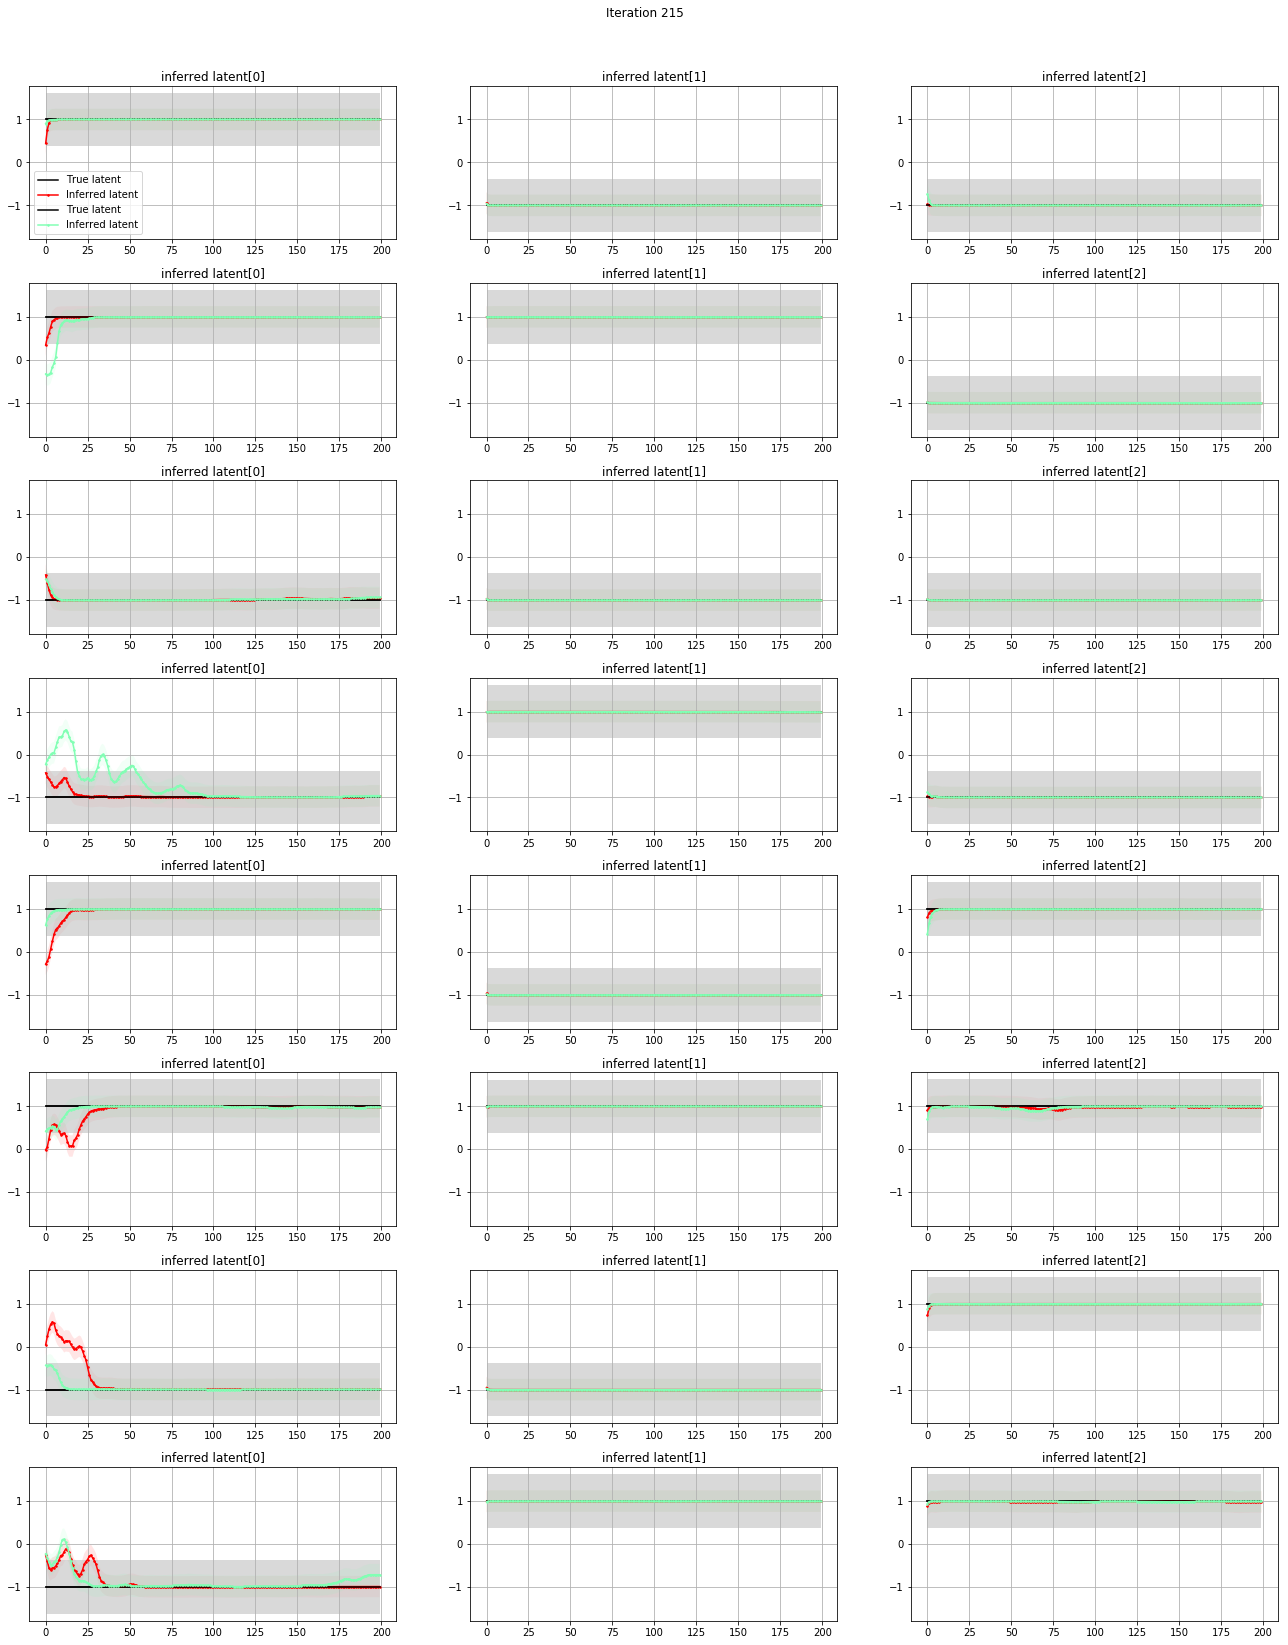

In [152]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

title = 'Iteration %i' % itr
ntasks = samples["tasks"][0].shape[1]
print("Tasks:", ntasks)
nlatents = samples["latents"][0].shape[1]
print("Latents:", nlatents)
nrollouts = 2
fig = plt.figure(figsize=(nlatents * 6, ntasks * 3))
fig.suptitle(title)

infer_axes = []
colormap = lambda x: matplotlib.cm.get_cmap("rainbow")(1. - x)

gs0 = gridspec.GridSpec(ntasks, 1)
for task in range(ntasks):
    gs00 = gridspec.GridSpecFromSubplotSpec(1, nlatents,
                                            subplot_spec=gs0[task])
    path_length = samples["latent_infos"]["mean"][tasks[task][0]].shape[0]
    xs = np.arange(0, path_length)
    for li in range(nlatents):
        infer_ax = plt.Subplot(fig, gs00[li])
        infer_ax.set_title("inferred latent[%i]" % li)
        infer_ax.grid()
        if task > 0:
            infer_ax.get_shared_x_axes().join(infer_ax, infer_axes[li])
            infer_ax.get_shared_y_axes().join(infer_ax, infer_axes[li])
        for i in range(nrollouts):
            embedding_mean = samples["latent_infos"]["mean"][tasks[task][i]][0]
            embedding_std = np.exp(samples["latent_infos"]["log_std"][tasks[task][i]][0])
            true_mu, true_sigma = embedding_mean[li], embedding_std[li]
            infer_ax.fill_between(xs,
                                  np.ones_like(xs) * (true_mu + 2.5 * true_sigma),
                                  np.ones_like(xs) * (true_mu - 2.5 * true_sigma),
                                  facecolor="lightgrey",
                                  alpha=.6,
                                  zorder=1)
            infer_ax.plot(xs, np.ones_like(xs) * true_mu, color="black", zorder=2, label="True latent")
        
            mus = samples["trajectory_infos"]["mean"][tasks[task][i]][:, li]
            sigmas = np.exp(samples["trajectory_infos"]["log_std"][tasks[task][i]][:, li])
            infer_ax.fill_between(xs,
                                  mus + sigmas,
                                  mus - sigmas,
                                  facecolor=colormap(i * 1. / nrollouts),
                                  alpha=.1,
                                  zorder=1)
            infer_ax.plot(xs, mus, color=colormap(i * 1. / nrollouts), marker='o', markersize=1.5, zorder=2,
                         label="Inferred latent")
        if task == 0 and li == 0:
            infer_ax.legend()
        infer_axes.append(infer_ax)
        fig.add_subplot(infer_ax)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig("inference_net_%i.png" % itr)

Tasks: 8
Latents: 3


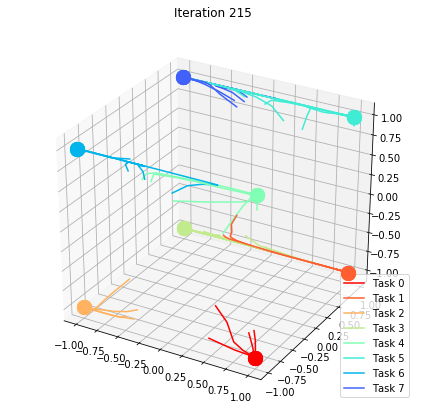

In [153]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

all_rollouts_in_one_plot = True

title = 'Iteration %i' % itr
ntasks = samples["tasks"][0].shape[1]
print("Tasks:", ntasks)
nlatents = samples["latents"][0].shape[1]
print("Latents:", nlatents)
nrollouts = 4

assert(nlatents == 2 or nlatents == 3)

infer_axes = []
colormap = lambda x: matplotlib.cm.get_cmap("rainbow")(1. - x)

if all_rollouts_in_one_plot:
    fig = plt.figure(figsize=(6, 6))
else:
    fig = plt.figure(figsize=(nrollouts * 6, 6))
    gs0 = gridspec.GridSpec(1, nrollouts)
fig.suptitle(title)
if all_rollouts_in_one_plot:
    if nlatents == 2:
        infer_ax = fig.add_subplot(111)      
    else:
        from mpl_toolkits import mplot3d
        infer_ax = fig.add_subplot(111, projection='3d')
    infer_ax.grid()
for i in range(nrollouts):
    if not all_rollouts_in_one_plot:
        if nlatents == 2:
            infer_ax = fig.add_subplot(gs0[i])      
        else:
            from mpl_toolkits import mplot3d
            infer_ax = fig.add_subplot(gs0[i], projection='3d')
        if i > 0:
            infer_ax.get_shared_x_axes().join(infer_ax, infer_axes[0])
            infer_ax.get_shared_y_axes().join(infer_ax, infer_axes[0])

        infer_ax.set_title("rollout %i" % (i+1))
        infer_ax.grid()
    for task in range(ntasks):
        if i >= len(tasks[task]):
            continue
        inferred_latent = samples["trajectory_infos"]["mean"][tasks[task][i]]
        true_latent = samples["latent_infos"]["mean"][tasks[task][i]][0]

        color = colormap(task * 1. / ntasks)    
        if nlatents == 2:            
            infer_ax.scatter([true_latent[0]], [true_latent[1]], s=200, zorder=2, c=color)
            infer_ax.plot(inferred_latent[:,0], inferred_latent[:,1], zorder=2,
                         label="Task %i" % task, c=color)
        else:
            infer_ax.scatter([true_latent[0]], [true_latent[1]], [true_latent[2]], s=200, zorder=2, c=color)
            infer_ax.plot(inferred_latent[:,0], inferred_latent[:,1], inferred_latent[:,2], zorder=2,
                         label="Task %i" % task, c=color)
    if i == 0:
        infer_ax.legend()
    infer_axes.append(infer_ax)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig("inference_net_%i.png" % itr)